In [121]:
from bankingSystem import * 
from helperFunctions import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import warnings 
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%pylab inline 
pylab.rcParams['figure.figsize'] = (20, 20)
pylab.rcParams['font.size'] = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [123]:
def run(iRun):
    np.random.seed(iRun+1000)
    # simulation and data collection
    simulationSteps = 500
    model = bankingSystem(banksFile="balanceSheetAnalysis/banksData_2022.csv", # csv file used to initialize the bank agents
                    leverageRatio = 20.0,                                     # leverage ratio upper bound for all banks
                    depositReserve = 0.2,                                     # capital reserve as a ratio of portfolio value
                    num_borrowing= 5,                                        # number of borrowing request per bank per step
                    sizeOfBorrowing = 1.0, concentrationParameter = None,                                      # size of borrowing as a ratio of equity capital
                    num_banks=100,                                            # number of banks in the system 
                    alpha = 0.5,                                              # portfolio recovery rate                           
                    beta = 0.9,                                               # interbank loan recovery rate
                    fedRate = 0.04,                                            # interest rate on borrowing   
                    portfolioReturnRate = 0.10,          
                    # return rate on portfolio
                    returnVolatiliy = 0.18,
                    returnCorrelation = 0.8,
                    liquidityShockNum = 10,                                    # number of liquidity shocks per step      
                    shockSize = 0.02,                                          # size of the shock
                    shockDuration = [-1, -1]) # duration of the shock
                    
    model.datacollector.collect(model)
    for _ in range(simulationSteps):
        model.simulate()
        
    agent_data = model.datacollector.get_agent_vars_dataframe()
    model_data = model.datacollector.get_model_vars_dataframe()
    return model.concentrationParameter

### model without the exogeous shock

In [124]:
import multiprocessing
def multiRun(numberOfruns):
    # running the simulation in parallel
    cpuNum = 48
    results = []
    batchNum = 0
    while numberOfruns > 0:
        print(numberOfruns)
        if numberOfruns > cpuNum:
            numberOfruns = numberOfruns - cpuNum
            with multiprocessing.Pool() as pool:
                # run the function in parallel on the input values
                results = results + pool.map(run, range(batchNum*cpuNum, (batchNum+1)*cpuNum))
            batchNum = batchNum + 1
        else:
            with multiprocessing.Pool() as pool:
                results = results + pool.map(run, range(batchNum*cpuNum, batchNum*cpuNum + numberOfruns))
            numberOfruns = 0
    return results

results = multiRun(1000)



1000
952
904
856
808
760
712
664
616
568
520
472
424
376
328
280
232
184
136
88
40


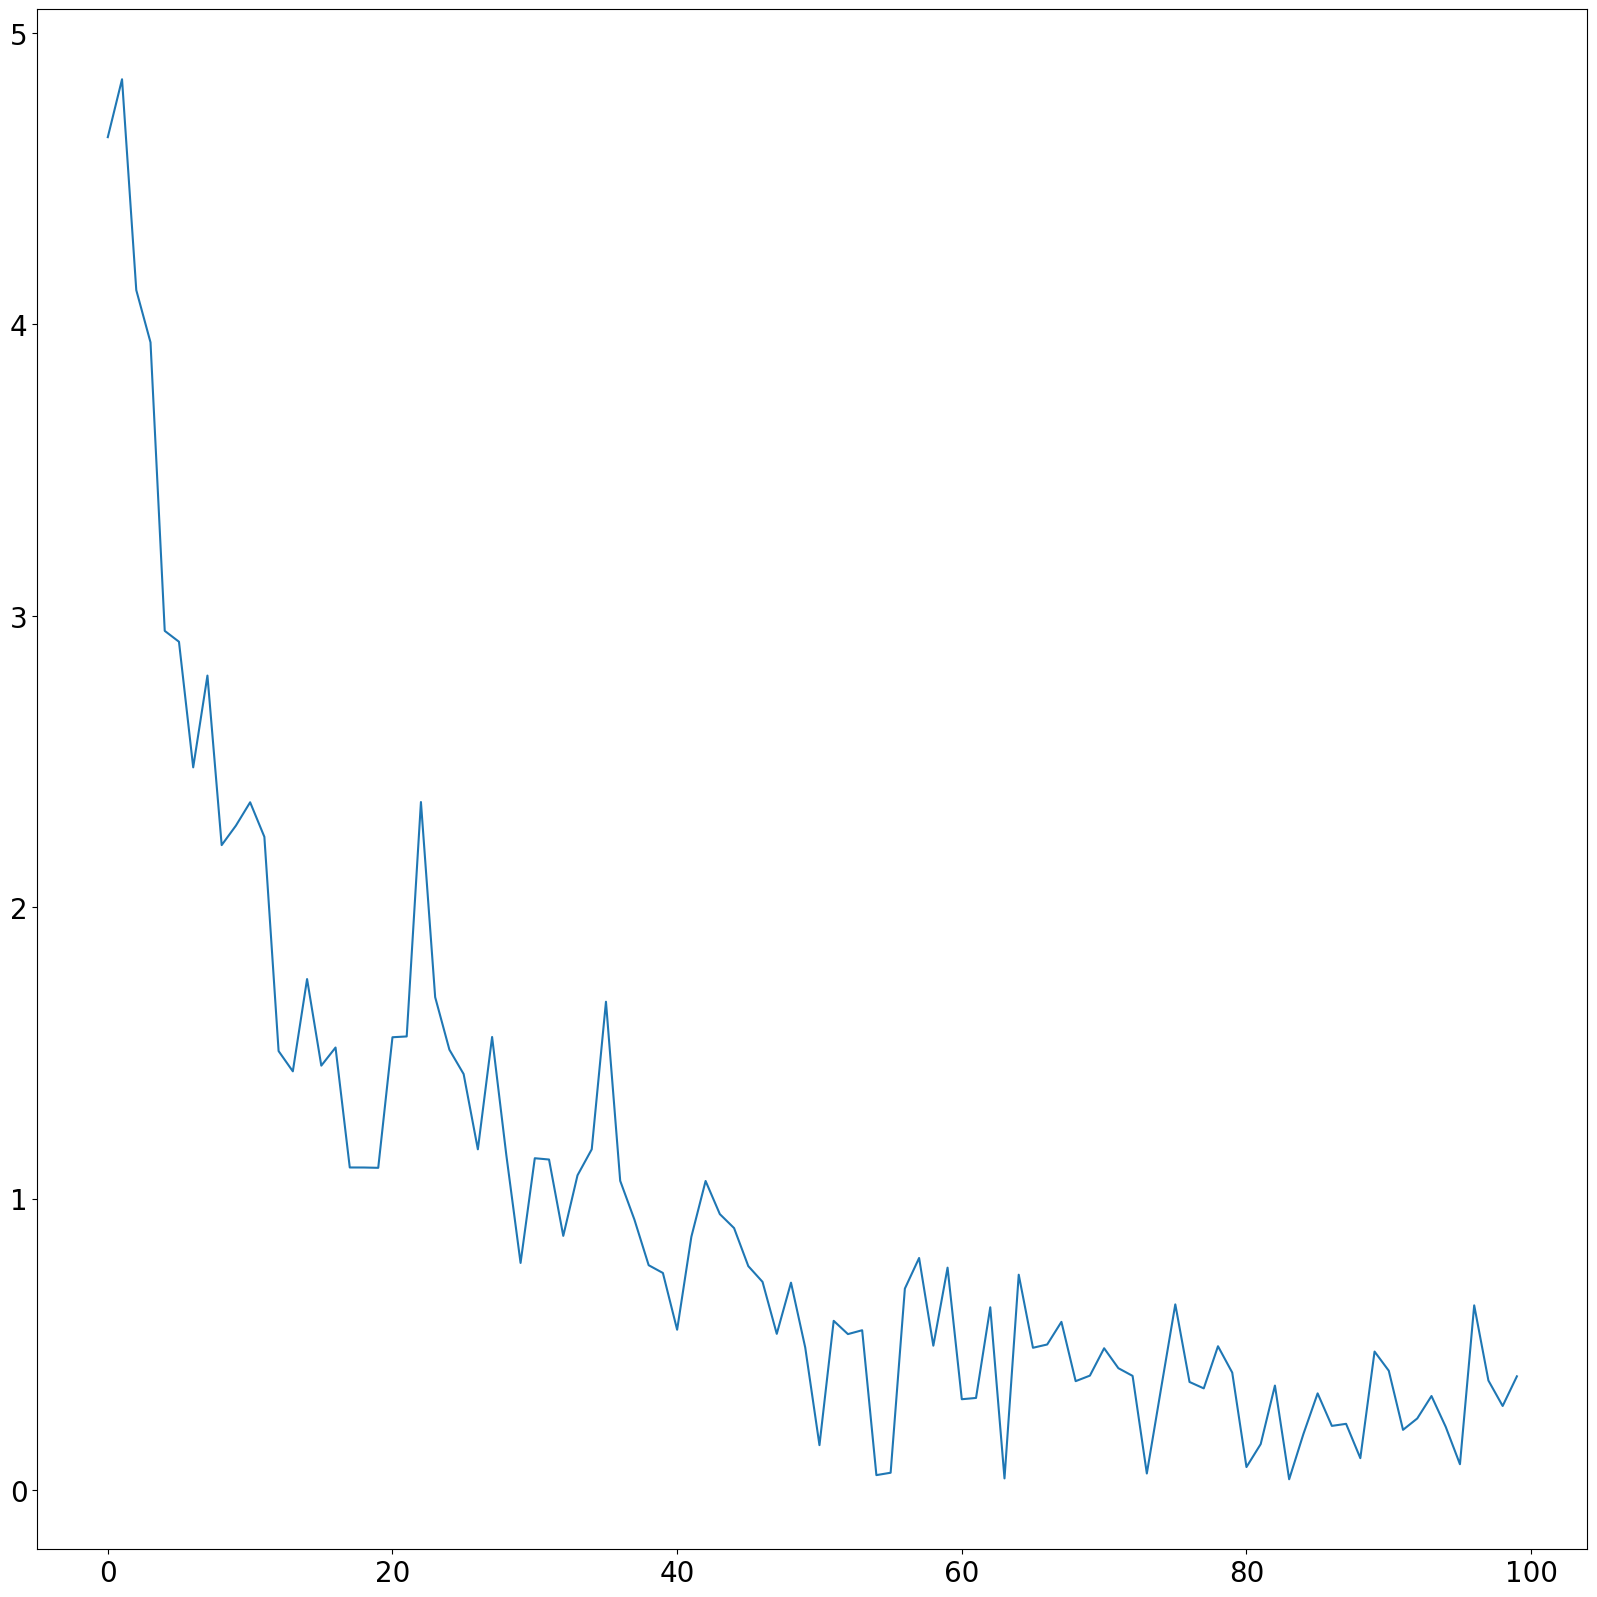

In [125]:
plt.plot(model.trustMatrix.sum(axis=0))

In [103]:
# Distribution of in-degrees and out-degrees across banks
IndegreeCollection = np.array([(model_data["Liability Matrix"][j]>0).sum(axis=0) for j in range(simulationSteps)])
OutdegreeCollection = np.array([(model_data["Liability Matrix"][j]>0).sum(axis=1) for j in range(simulationSteps)])

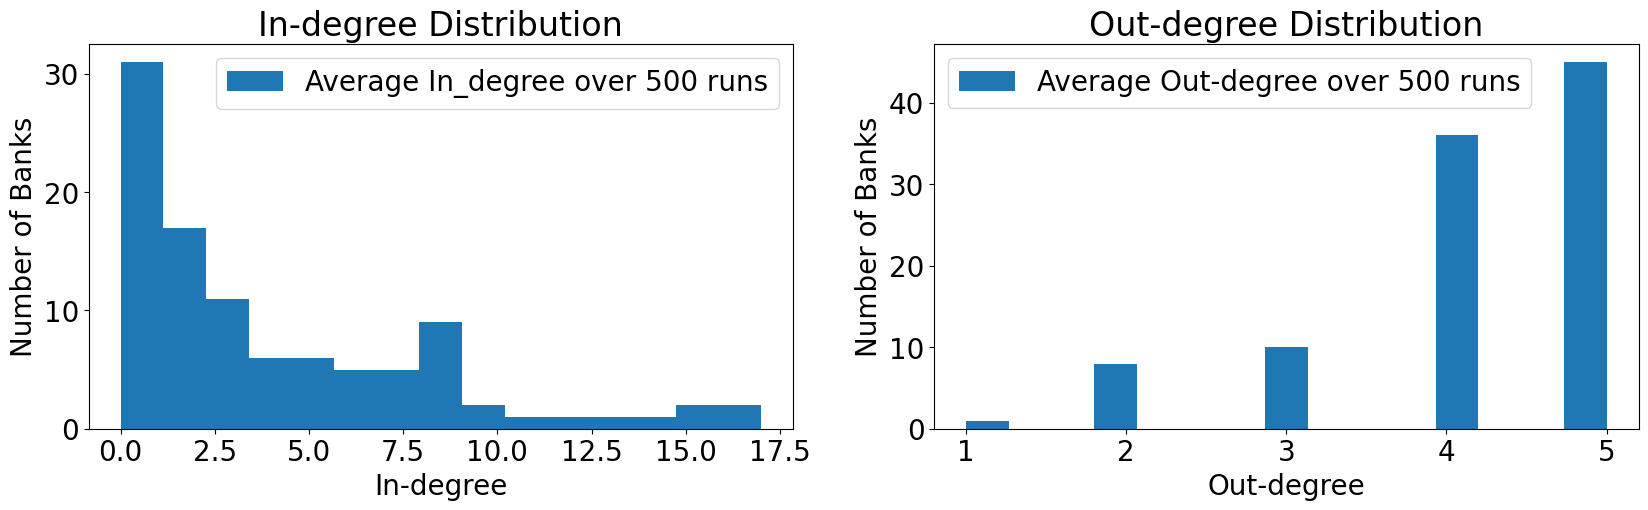

In [104]:
def plot_degree_distribution(t):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 5)
    ax1.set_title("In-degree Distribution")
    ax1.hist(IndegreeCollection[t], label="Average In_degree over 500 runs", bins=15)
    ax1.set_xlabel("In-degree")
    ax1.set_ylabel("Number of Banks")
    ax1.legend()

    ax2.set_title("Out-degree Distribution")
    ax2.hist(OutdegreeCollection[t], label="Average Out-degree over 500 runs", bins=15)
    ax2.set_xlabel("Out-degree")
    ax2.set_ylabel("Number of Banks")
    ax2.legend()
    plt.show()

plot_degree_distribution(999)

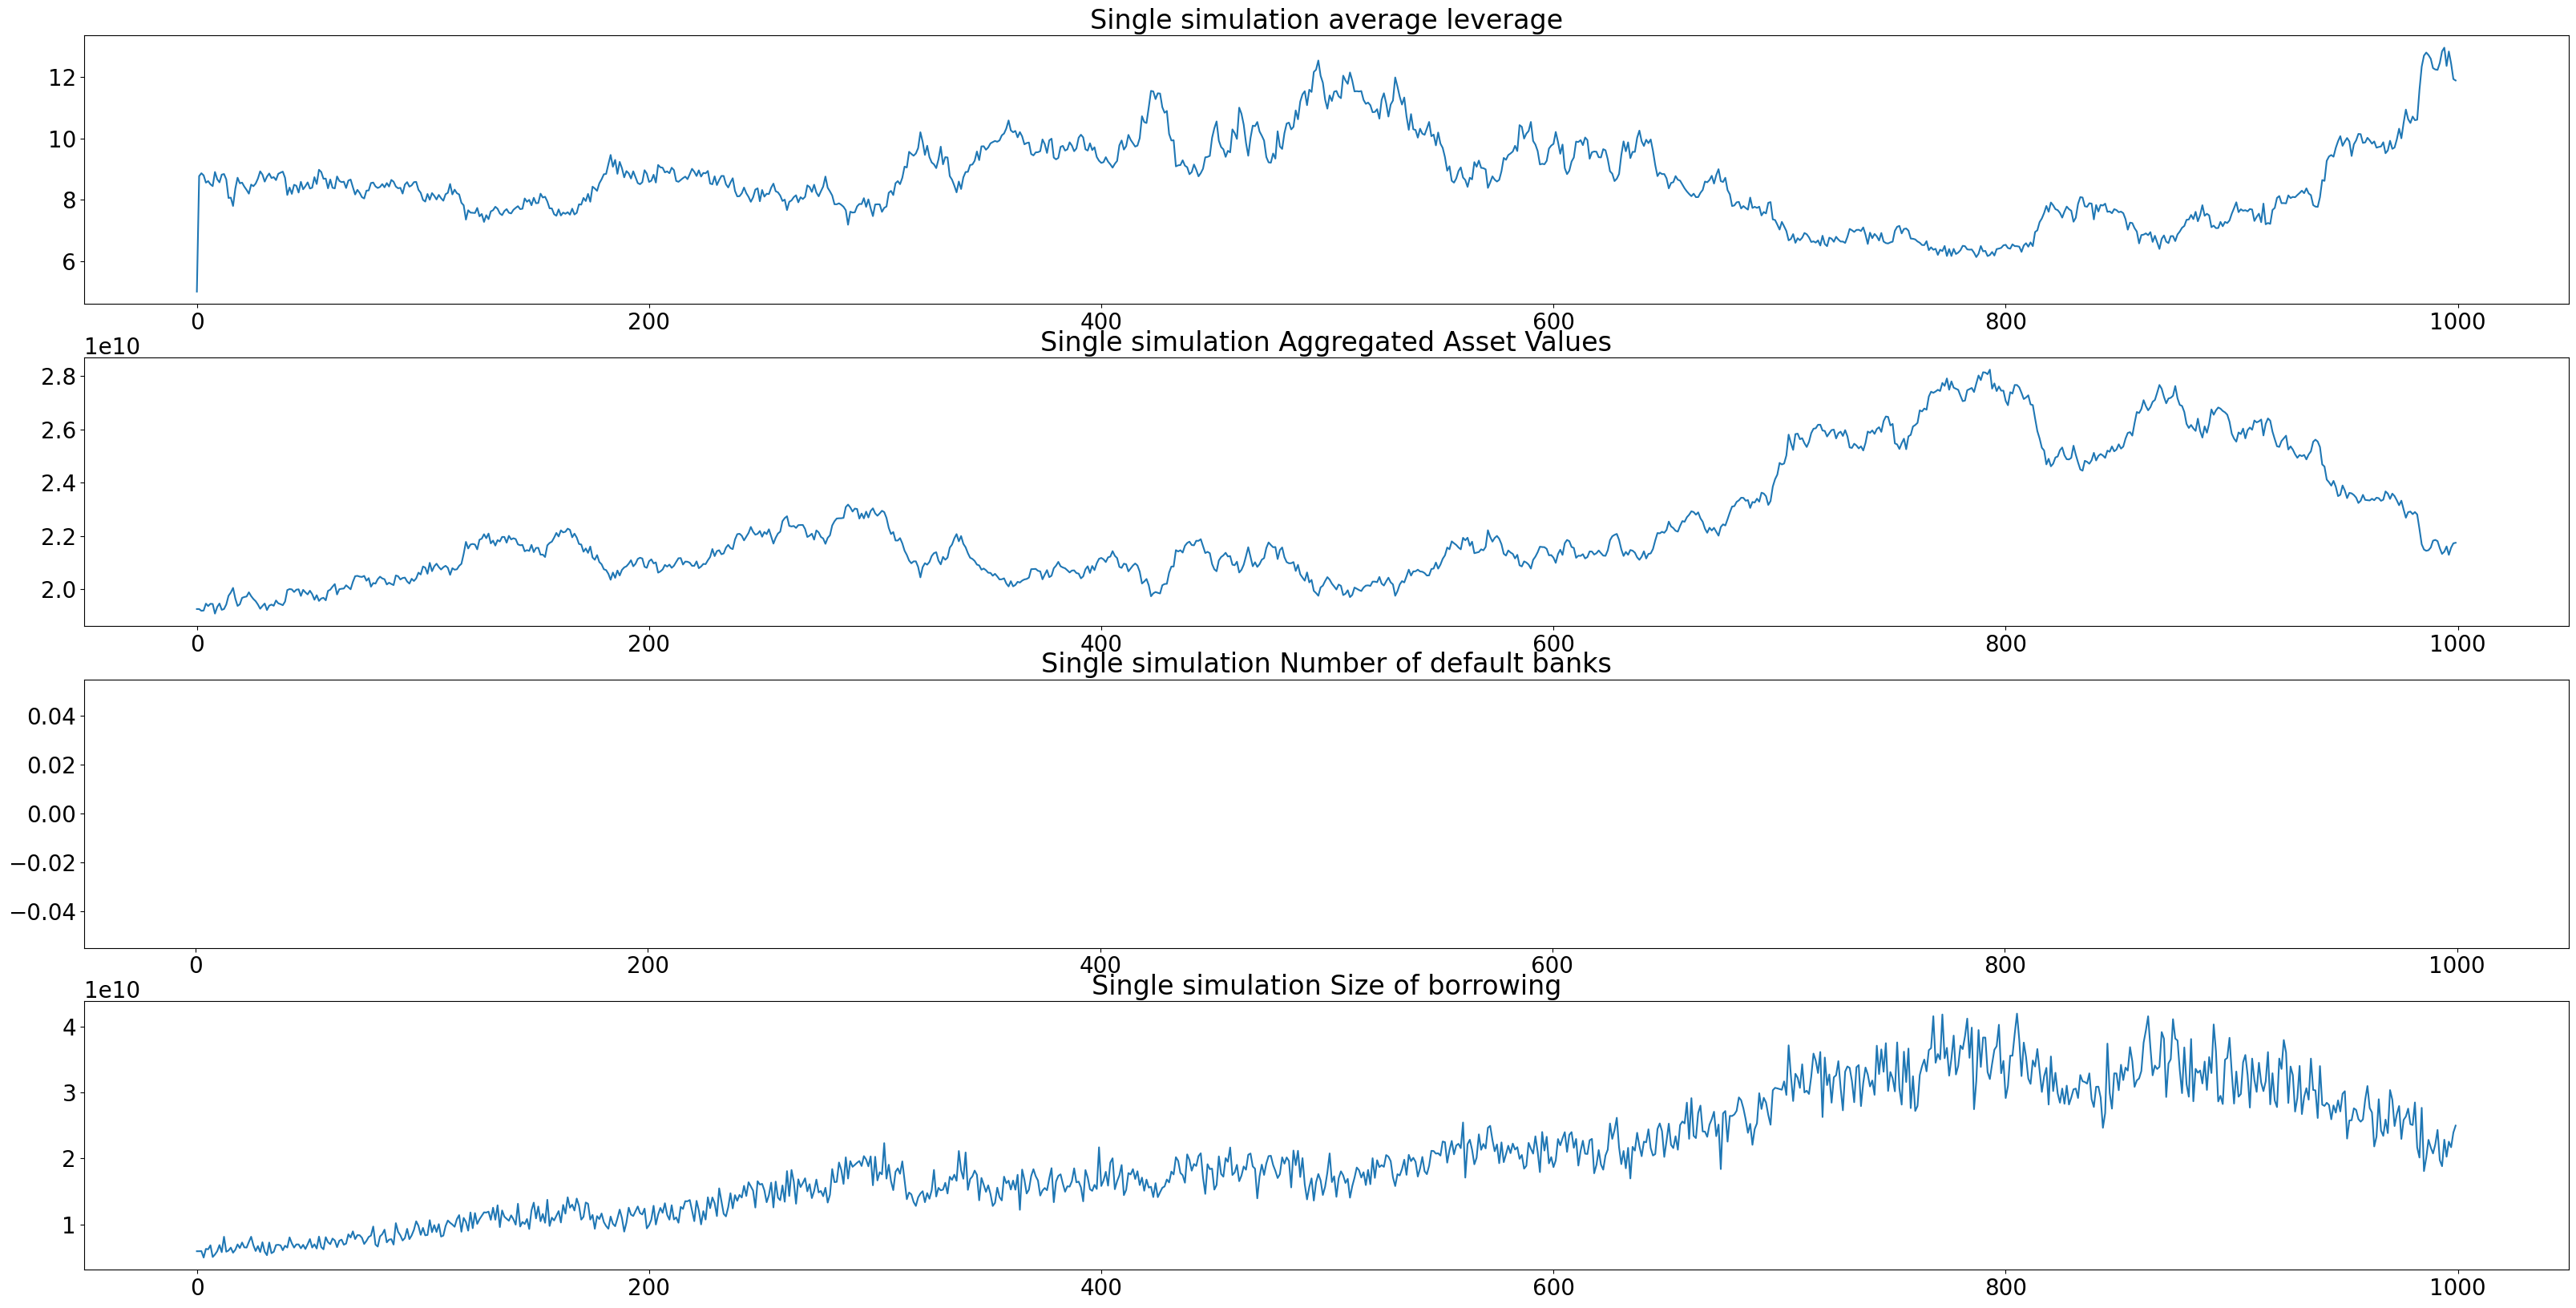

In [105]:
simulationMonitor(agent_data, model_data, simulationSteps)

In [106]:
def netWorkGraph(matrix, model, printLabel=True):
    size = model.N
    # Create a graph object with 5 nodes
    G = nx.DiGraph(seed=1)
    G.add_nodes_from(list(range(size)))
    # Create a list of edge weights
    weightedEdges = []
    for i in range(size):
        for j in range(size):
            if matrix[i][j] > 0.01:
                # direction of the edge is the direction of the money flow
                weightedEdges.append((j, i, matrix[i][j]))
    G.add_weighted_edges_from(weightedEdges)
    nodeSize = matrix.sum(axis=0) * 500
    bigLabelIndex = np.where(nodeSize >= np.percentile(nodeSize, 96))[0]
    bigLabel = [model.banks[i] if i in bigLabelIndex else "" for i in range(size)]
    # Set the labels for the nodes using a list of variables
    label_dict = {node: label for node, label in zip(G.nodes, bigLabel)}
    edges = G.edges()
    edgesWidth = [G[u][v]['weight'] * 5 for u,v in edges]
    # change the color of the center nodes
    node_colors = ['red' if node in bigLabelIndex else 'lightblue' for node in G.nodes()]
    pos = nx.fruchterman_reingold_layout(G, scale=10, k=1, iterations=100)
    nx.draw_networkx_nodes(G, pos, node_size=nodeSize,node_color=node_colors, alpha=0.9)
    if printLabel:
        label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
        nx.draw_networkx_labels(G, pos,labels = label_dict,
                                font_size=10, bbox=label_options)
    nx.draw_networkx_edges(G, pos, width=edgesWidth, alpha=0.5, connectionstyle="arc3,rad=0.05")
    plt.axis('off')
    plt.show()

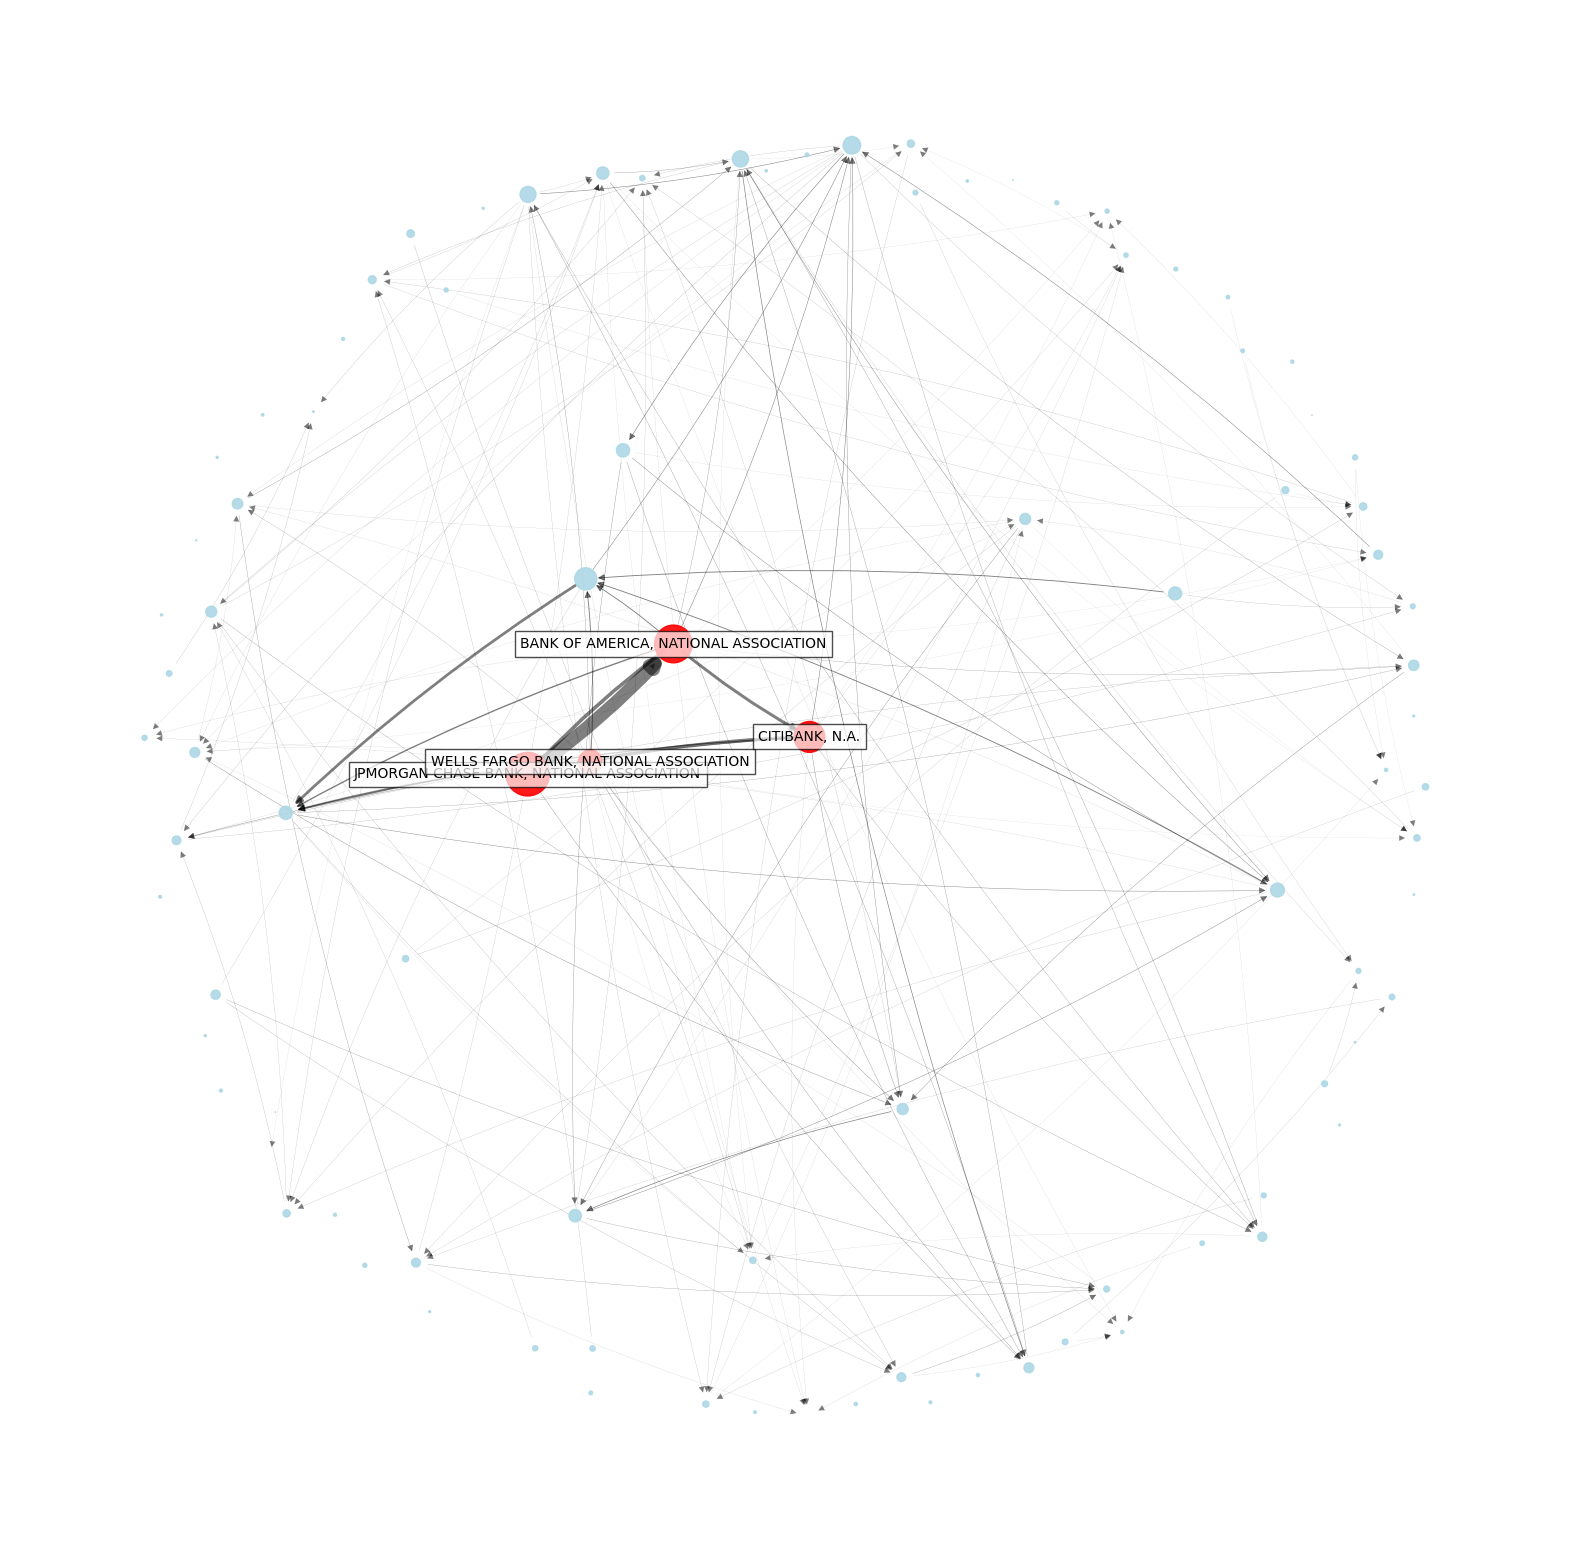

In [107]:
step = 450
netWorkGraph(model_data["Liability Matrix"][step]/model_data["Liability Matrix"][step].sum()*10, model, printLabel=True)

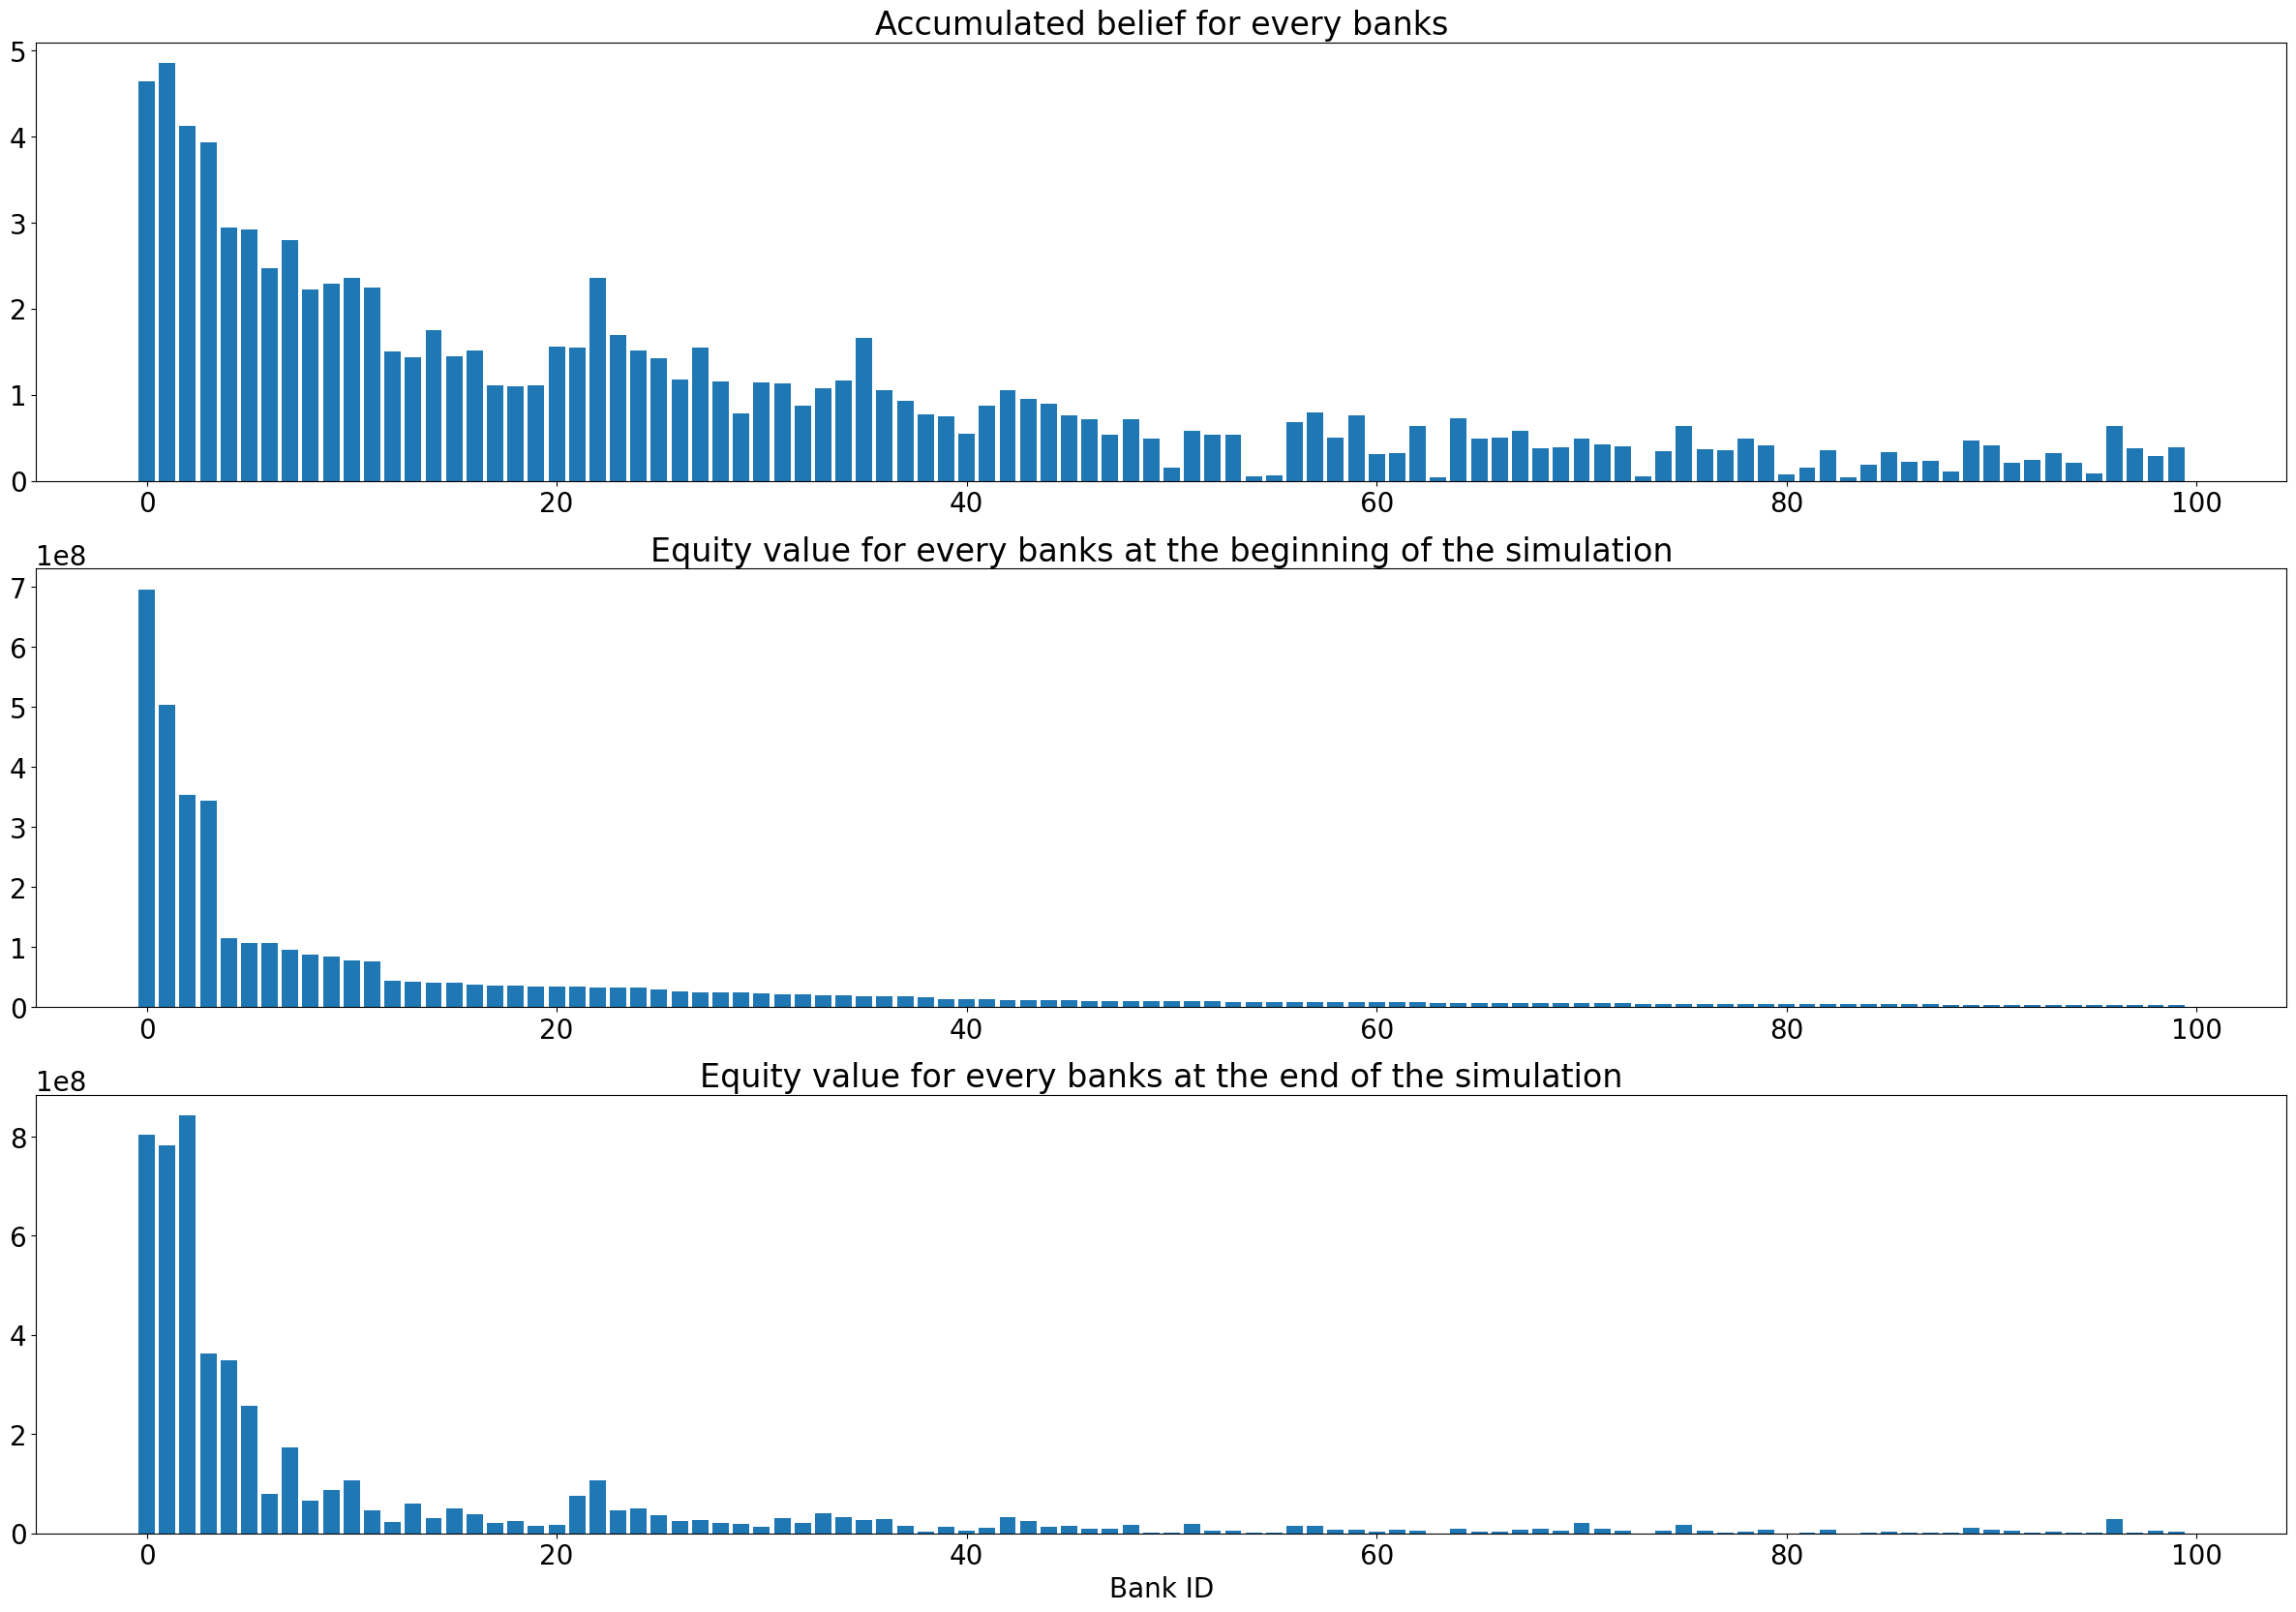

In [108]:
# bar chart of portfolio value
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.set_size_inches(30, 20)
ax1.bar(range(100), model_data["Trust Matrix"][simulationSteps].sum(axis = 0))
ax1.set_title("Accumulated belief for every banks")
ax2.bar(range(100), agent_data.xs(0, level="Step")["Equity"])
ax2.set_title("Equity value for every banks at the beginning of the simulation")
ax3.bar(range(100), agent_data.xs(500, level="Step")["Equity"])
ax3.set_title("Equity value for every banks at the end of the simulation")
ax3.set_xlabel("Bank ID")
plt.show()